<a href="https://colab.research.google.com/github/wilkeraziz/emnlp-main-findings/blob/main/gamma-poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up numpyro

In [1]:
!pip install numpyro funsor

# Data

I'm using the counts Ryan shared:

In [2]:
!git clone https://github.com/ryancotterell/emnlp2020-analysis.git

fatal: destination path 'emnlp2020-analysis' already exists and is not an empty directory.


In [3]:
def read(fname):
	lst = []
	with open(fname, 'r') as f:
		for i, line in enumerate(f):
			if i == 0:
				continue
			split = line.strip().split("\t")
			lst.append(int(split[1]))
	return lst

In [4]:
y_m = read('emnlp2020-analysis/data/main.tsv')
y_f = read('emnlp2020-analysis/data/findings.tsv')

Let's visualise it

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

from tabulate import tabulate
import numpy as np
from collections import OrderedDict
from itertools import cycle

In [6]:
palette = cycle(sns.color_palette())
color_m = next(palette)
color_f = next(palette)

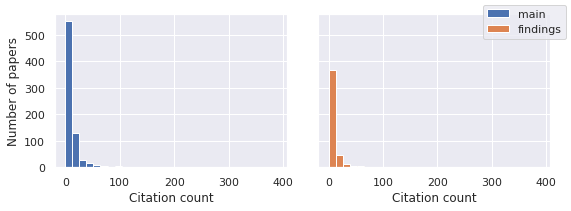

In [7]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3))
bins = np.histogram_bin_edges(np.concatenate([y_m, y_f]), bins=30)
ax[0].hist(y_m, bins=bins, color=color_m, label='main')
ax[1].hist(y_f, bins=bins, color=color_f, label='findings')
ax[0].set_xlabel('Citation count')
ax[0].set_ylabel('Number of papers')
ax[1].set_xlabel('Citation count')
fig.tight_layout(h_pad=2, w_pad=2)
_ = fig.legend()

Let's get some descriptive statistics

In [8]:
headers = ['Main', 'Findings']
rows = [
    ['samples', len(y_m), len(y_f)],
    ['mean', np.mean(y_m), np.mean(y_f)],
    ['std', np.std(y_m), np.std(y_f)],
    ['median', np.median(y_m), np.median(y_f)],
    ['min', np.min(y_m), np.min(y_f)],
    ['max', np.max(y_m), np.max(y_f)],
]
print(tabulate(rows, headers=headers, floatfmt='.2f'))

           Main    Findings
-------  ------  ----------
samples  751.00      447.00
mean      11.60        9.19
std       20.20       23.95
median     7.00        4.00
min        0.00        0.00
max      355.00      388.00


# Model

I will attempt to model each group under a group-specific Poisson distribution. As the Poisson parameters are unknown, I will sample them from a fixed shared Gamma prior. 

I'm quite sure our data are more complex than what this model can capture, and that this model is not able to credibly shed light onto latent patterns in the data. But, the fact that we can detect this model's inability to account for what we need, and the fact that we can overcome its simplicity in an intutive way are precisely what makes Bayesian estimation so powerful.

**Generative story**

Here I use $[N]$ for the set $\{1, \ldots, N\}$. We have $N$ observations, each $y_n$ is the citation count of a paper in group $x_n \in [G]$, and in this analysis we have two groups (main, findings).

\begin{align}
\alpha &\sim \mathrm{Exponential}(a) \\
\beta &\sim \mathrm{Exponential}(b) \\
\lambda_g &\sim \mathrm{Gamma}(\alpha, \beta) &\text{for }g \in [G]\\
Y_n|x_n &\sim \mathrm{Poisson}(\lambda_{x_n}) &\text{for }n \in [N]
\end{align}

In [9]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp

NUM_CHAINS = 4
numpyro.set_host_device_count(NUM_CHAINS)

print(f"Running on NumPryo v{numpyro.__version__}")

Running on NumPryo v0.8.0


In [10]:
class GammaPoisson:
    def __init__(self, group_names: list, observations: list, rate_a=1., rate_b=1.,
                 num_samples=1000, num_chains=1, num_warmup=100):

        self.rate_a = rate_a
        self.rate_b = rate_b
        
        self.group_names = group_names
        self.G = len(group_names)
        
        self.N = sum(len(y) for y in observations)
        # [N]
        self.x = np.concatenate([[g] * len(y) for g, y in enumerate(observations)])
        self.y = np.concatenate(observations)

        self.num_samples = num_samples
        self.num_chains = num_chains
        self.num_warmup = num_warmup

        self.rng_key = random.PRNGKey(0)

        nuts_kernel = NUTS(self.model)
        self.mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
        
        self.prior_predictive = None
        self.posterior_predictive = None
        self.posterior_samples = None

    def model(self, y=None):
        """
        Pyro joint distribution.
        
        Parameter:
        
        y: observations as returned by self.prepare or None. 
            If None, the 'obs' node of the graphical model will be resampled.
        """

        N, G = self.N, self.G

        alpha = numpyro.sample("alpha", dist.Exponential(self.rate_a))
        beta = numpyro.sample("beta", dist.Exponential(self.rate_b))
        
        with numpyro.plate("groups", G):  
            # construct the components
            # [G]
            lamb = numpyro.sample("lambda", dist.Gamma(alpha, beta))        
        
        with numpyro.plate("observations", N):
            # [N]
            # Construct the likelihood function            
            return numpyro.sample("y", dist.Poisson(lamb[self.x]), obs=y)

    def run(self):
        self.mcmc.run(self.rng_key, y=self.y)
        self.mcmc.print_summary()
        self.posterior_samples = self.mcmc.get_samples(group_by_chain=False)
        print("posterior samples shapes:")
        for k, v in self.posterior_samples.items():
            print(k, v.shape)

    def make_prior_predictive(self, num_prior_samples=100):        
        if self.prior_predictive is None:
            self.prior_predictive = Predictive(self.model, num_samples=num_prior_samples)

    def draw_prior_predictions(self):
        if self.prior_predictive is None:
            self.make_prior_predictive()
        rng_key, rng_key_ = random.split(self.rng_key)        
        return self.prior_predictive(rng_key_, y=None)["y"]

    def make_posterior_predictive(self):
        if self.posterior_samples is None:
            raise RuntimeError("You need to run the sampler first")        
        if self.posterior_predictive is None:
            self.posterior_predictive = Predictive(self.model, self.posterior_samples)        

    def draw_posterior_predictions(self, plot=False):
        if self.posterior_predictive is None:
            self.make_posterior_predictive()        
        rng_key, rng_key_ = random.split(self.rng_key)
        return self.posterior_predictive(rng_key_, y=None)["y"]

These helper functions will help us analyse our prior and posterior samples.

The first one plots data samples side by side with model samples using approximate density plots.

The second one plots the distribution of certain statistics of model samples against the observed value of that statistic (e.g., mean, std, median).  

In [24]:
def plot_predictions(model, samples, bins=[20, 100], density=[True, True], sharex=True, sharey=True):
    fig, ax = plt.subplots(model.G, 2, sharex=sharex, sharey=sharey, figsize=(10, 5))
    pal = cycle(sns.color_palette())
    for k in range(model.G):
        
        yk = model.y[model.x==k]
        yk_ = samples[:,model.x==k]
        c = next(pal)
        _ = ax[k, 0].hist(yk, bins=bins[0], color=c, density=density[0])
        _ = ax[k, 0].set_xlabel(f'obs: {model.group_names[k]}')
        _ = ax[k, 1].hist(yk_.flatten(), bins=bins[1], color=c, density=density[1])
        _ = ax[k, 1].set_xlabel(f'predictive: {model.group_names[k]}')

    fig.tight_layout(h_pad=2, w_pad=2)
    fig.show()

def plot_checks(model, samples, bins=30):
    fig, ax = plt.subplots(model.G, 4, sharex=False, figsize=(15, 5))
    pal = cycle(sns.color_palette())
    for k in range(model.G):
        c = next(pal)
        yk = model.y[model.x==k]
        yk_ = samples[:,model.x==k]
        
        _ = ax[k, 0].hist(np.mean(yk_, 1), bins=bins, color=c, label='pred' if k == 0 else None)
        _ = ax[k, 0].axvline(np.mean(yk), color='black', linestyle='--', label='obs' if k == 0 else None)    
        _ = ax[k, 0].set_xlabel(f'E[Y{k}]')
        
        _ = ax[k, 1].hist(np.std(yk_, 1), color=c, bins=bins)    
        _ = ax[k, 1].axvline(np.std(yk), color='black', linestyle='--')
        _ = ax[k, 1].set_xlabel(f'std[Y{k}]')

        _ = ax[k, 2].hist(np.median(yk_, 1), color=c, bins=bins)    
        _ = ax[k, 2].axvline(np.median(yk), color='black', linestyle='--')
        _ = ax[k, 2].set_xlabel(f'median[Y{k}]')

        pvalues = np.mean(yk_ > yk, 1)
        _ = ax[k, 3].hist(pvalues, bins=bins)
        _ = ax[k, 3].set_xlabel(f'Pr(Y{k} > obs{k})')
        _ = ax[k, 3].axvline(np.median(pvalues), color='black', linestyle=':', label='median' if k==0 else None)

    _ = fig.legend(loc='upper center', ncol=3)
    fig.tight_layout(h_pad=2, w_pad=2)
    fig.show()


# MCMC 

I won't really implement MCMC, I'm going to count on Numpyro for that.

In [12]:
model = GammaPoisson(
    ['main', 'findings'], [y_m, y_f], 
    rate_a=0.1, rate_b=1.,
    num_chains=NUM_CHAINS, num_warmup=2000, num_samples=5000)

## Prior predictive

Plotting samples from the prior predictive distribution (i.e., sampling from the generative story without conditioning on any observations) is a good way to check whether our prior is reasonable. 

We want to see a predictive curve that could easily include any of our groups.

In [13]:
prior_samples = model.draw_prior_predictions()
prior_samples.shape

(100, 1198)

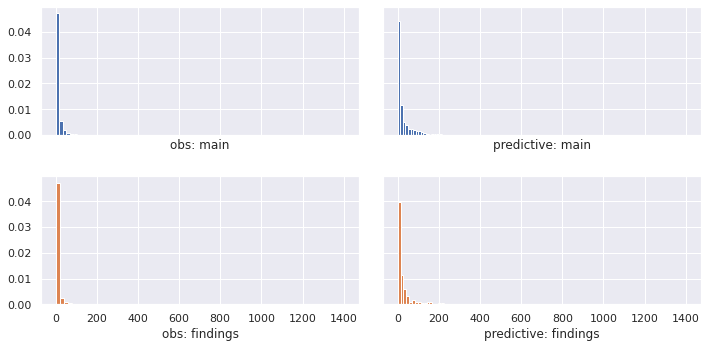

In [25]:
_ = plot_predictions(model, prior_samples)

We can also plot some statistics just to see whether indeed our prior is not excluding plausible observations.

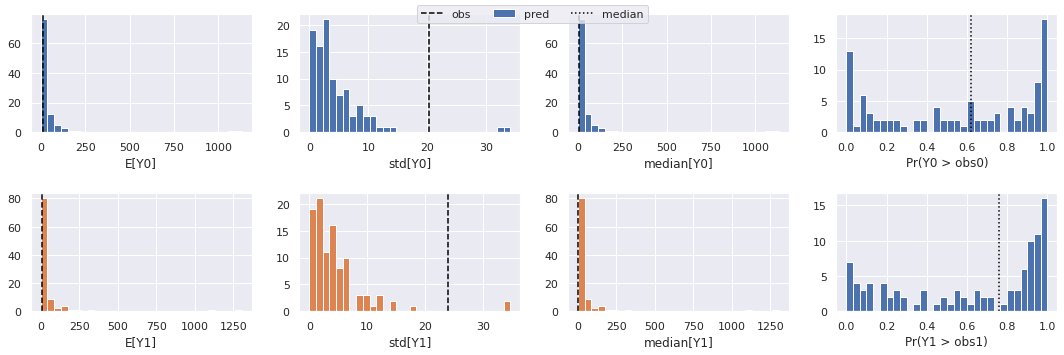

In [15]:
_ = plot_checks(model, prior_samples)

## Posterior

Time to run our sampler. Numpyro is fast!

In [16]:
model.run()

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     12.13      7.75     10.48      1.26     23.06   6422.81      1.00
      beta      1.16      0.76      1.00      0.10      2.21   6287.87      1.00
 lambda[0]     11.60      0.12     11.60     11.39     11.80  12567.07      1.00
 lambda[1]      9.19      0.14      9.19      8.96      9.43  13662.08      1.00

Number of divergences: 4
posterior samples shapes:
alpha (20000,)
beta (20000,)
lambda (20000, 2)


## Posterior predictive

Before any analysis, let's see whether we can trust this model. It's good to plot samples from the posterior predictive distribution (i.e., sample from the generative story *after* conditioning on observations). These can be thought of as replications.

In [17]:
posterior_samples = model.draw_posterior_predictions()
posterior_samples.shape

(20000, 1198)

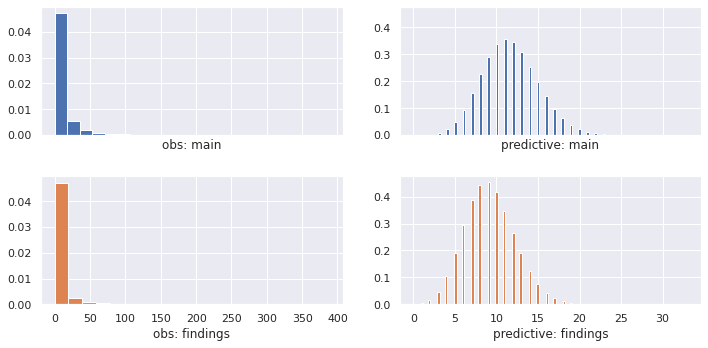

In [26]:
_ = plot_predictions(model, posterior_samples, sharex='col', sharey='col')

This is not looking very good, and, in fact, the next checks will show that this simple model cannot capture much more than the mean of the groups.

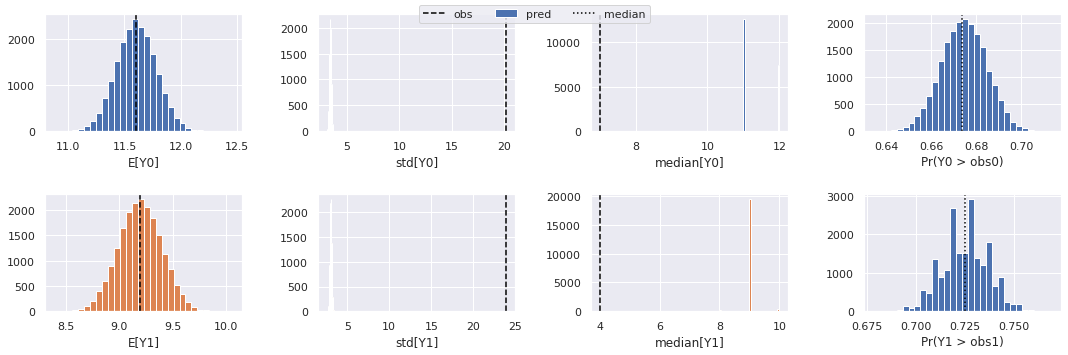

In [19]:
_ = plot_checks(model, posterior_samples)

It's reasonably clear to me, and hopefully to you too, that this model is simply not good for analysing the data we have. 

Thought I will plot some quantities in what follows, we simply cannot use them to support any argumentation, for we cannot really trust this analysis model.

In [20]:
print(tabulate([(k, v.shape) for k, v in model.posterior_samples.items()], headers=['rv', 'shape']))

rv      shape
------  ----------
alpha   (20000,)
beta    (20000,)
lambda  (20000, 2)


## Analysis of results


**Warning** these results cannot be trusted, not because MCMC failed (we have no evidence to suspect it did), but because the model is too simple to accomodate the complexity of the data (as per checks above).

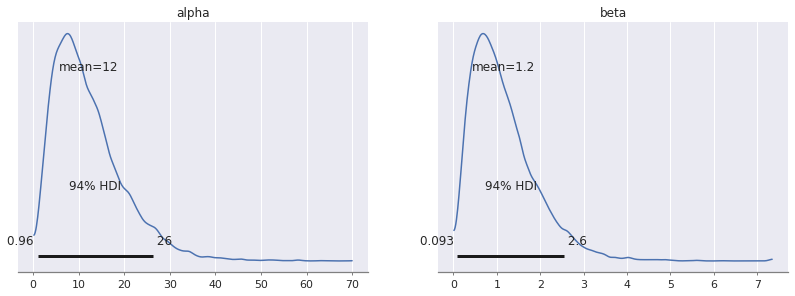

In [21]:
_ = az.plot_posterior(
    {
        'alpha': model.posterior_samples['alpha'], 
        'beta': model.posterior_samples['beta']
    }
)

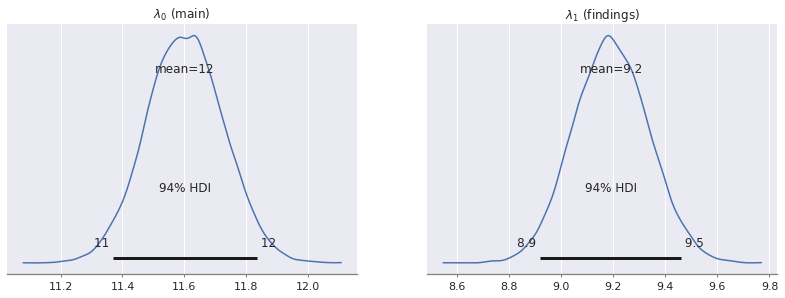

In [22]:
_ = az.plot_posterior(
    {
        r'$\lambda_{0}$ (main)': model.posterior_samples['lambda'][:,0], 
        r'$\lambda_{1}$ (findings)': model.posterior_samples['lambda'][:,1]
     }
)

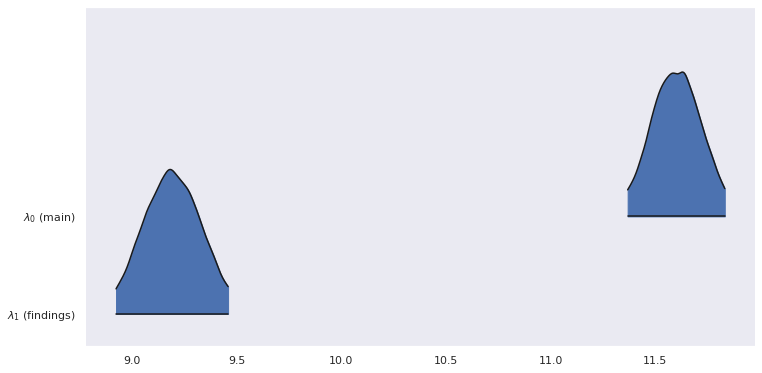

In [23]:
_ = az.plot_forest(
    {
        r'$\lambda_0$ (main)': model.posterior_samples['lambda'][:,0].reshape(model.num_chains, -1), 
        r'$\lambda_1$ (findings)': model.posterior_samples['lambda'][:,1].reshape(model.num_chains, -1)
    },
    kind='ridgeplot',
    combined=True,
)

See, if we had no means to criticise our own model, we might have rushed to declare EMNLP main conference's victory over Findings. 
